In [1]:
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv

load_dotenv()
file_path = os.getenv("FILE_PATH")
SNP_VIX_file = './data/S&P 500 VIX.csv'

### S&P500 VIX

In [2]:
# Load the CSV file into df
VIX = pd.read_csv(SNP_VIX_file)
VIX.columns = ["vol"]
VIX["log_vol_diff"] = np.log(VIX['vol']/ VIX['vol'].shift(1))
VIX.index = pd.to_datetime(VIX.index)
VIX = VIX.sort_index(ascending=True)
VIX = VIX[1:]
VIX['log_vol'] = np.log(VIX['vol'])

VIX.head()

,vol,log_vol_diff,log_vol
2015-01-05,19.92,-0.058496,2.991724
2015-01-06,21.12,0.089597,3.050220
2015-01-07,19.31,0.126822,2.960623
2015-01-08,17.01,-0.031253,2.833801
2015-01-09,17.55,-0.110476,2.865054


In [3]:
from hurst import compute_Hc
import plotly.graph_objects as go

def compute_rolling_hurst(df, window, col='log_vol', lag=0):
    hurst_values = []
    times = []
    
    # Loop through the DataFrame using the rolling window
    for i in range(window - 1, len(df), lag+1):
        # Extract the window slice from the series
        window_series = df[col].iloc[i - window + 1 : i + 1: lag+1]
        # Compute the Hurst exponent using the 'change' method and simplified calculation
        h, _, _ = compute_Hc(window_series, kind='change', simplified=True)
        
        hurst_values.append(h)
        times.append(df.index[i])
    
    # Create and return a new DataFrame with the computed Hurst exponents
    result_df = pd.DataFrame({'hurst': hurst_values}, index=times)
    return result_df

rolling_hurst_150 = compute_rolling_hurst(VIX, window=150, col='log_vol', lag=0)
rolling_hurst_350 = compute_rolling_hurst(VIX, window=300, col='log_vol', lag=0)
rolling_hurst_500 = compute_rolling_hurst(VIX, window=500, col='log_vol', lag=0)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=rolling_hurst_150.index,
    y=rolling_hurst_150["hurst"],
    mode='lines',
    name='150 days rolling window',
    line=dict(color='blue')
))
fig.add_trace(go.Scatter(
    x=rolling_hurst_350.index,
    y=rolling_hurst_350["hurst"],
    mode='lines',
    name='350 days rolling window',
    line=dict(color='red')
))
fig.add_trace(go.Scatter(
    x=rolling_hurst_500.index,
    y=rolling_hurst_500["hurst"],
    mode='lines',
    name='500 days rolling window',
    line=dict(color='green')
))
fig.update_layout(
    title=f"Hurst exponent for volatility",
    xaxis_title="Date",
    yaxis_title="Hurst Value",
    template="plotly_white"
)

### Run Monte Carlo simulations on fBM Model

In [4]:
import utils

vix_obj = utils.VixDf(VIX)
result_df = utils.apply_rolling_predictions_from_start(vix_obj, '2017-01-01', 250)
result_df["predicted_log_vol_diff"] = np.log(result_df["predicted"] / result_df["predicted"].shift(1))
result_df = result_df[1:]
result_df.head()

Day 252...
Day 253...
Day 254...
Day 255...
Day 256...
Day 257...
Day 258...
Day 259...
Day 260...
Day 261...
Day 262...
Day 263...
Day 264...
Day 265...
Day 266...
Day 267...
Day 268...
Day 269...
Day 270...
Day 271...
Day 272...
Day 273...
Day 274...
Day 275...
Day 276...
Day 277...
Day 278...
Day 279...
Day 280...
Day 281...
Day 282...
Day 283...
Day 284...
Day 285...
Day 286...
Day 287...
Day 288...
Day 289...
Day 290...
Day 291...
Day 292...
Day 293...
Day 294...
Day 295...
Day 296...
Day 297...
Day 298...
Day 299...
Day 300...
Day 301...
Day 302...
Day 303...
Day 304...
Day 305...
Day 306...
Day 307...
Day 308...
Day 309...
Day 310...
Day 311...
Day 312...
Day 313...
Day 314...
Day 315...
Day 316...
Day 317...
Day 318...
Day 319...
Day 320...
Day 321...
Day 322...
Day 323...
Day 324...
Day 325...
Day 326...
Day 327...
Day 328...
Day 329...
Day 330...
Day 331...
Day 332...
Day 333...
Day 334...
Day 335...
Day 336...
Day 337...
Day 338...
Day 339...
Day 340...
Day 341...
Day 342...

,predicted,conditional_vol,predicted_log_vol_diff
2016-01-06,19.397154,0.086494,-0.065095
2016-01-07,20.650110,0.087079,0.062594
2016-01-08,25.191872,0.087165,0.198801
2016-01-11,27.075924,0.087384,0.072124
2016-01-12,24.490392,0.087487,-0.100364


In [5]:
merged_df = result_df.join(VIX, how='inner')
merged_df.head()

,predicted,conditional_vol,predicted_log_vol_diff,vol,log_vol_diff,log_vol
2016-01-06,19.397154,0.086494,-0.065095,20.59,-0.193670,3.024806
2016-01-07,20.650110,0.087079,0.062594,24.99,-0.077731,3.218476
2016-01-08,25.191872,0.087165,0.198801,27.01,0.105731,3.296207
2016-01-11,27.075924,0.087384,0.072124,24.30,0.078295,3.190476
2016-01-12,24.490392,0.087487,-0.100364,22.47,-0.115456,3.112181


In [17]:
merged_df['log_vol_diff'].std()

0.07899149575970991

In [6]:
utils.compute_rmse(merged_df, 'predicted_log_vol_diff', 'log_vol_diff')

0.10995875868734488

In [7]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=merged_df.index,
    y=merged_df["predicted"],
    mode='lines',
    name='Predicted',
    line=dict(color='blue')
))
fig.add_trace(go.Scatter(
    x=merged_df.index,
    y=merged_df["vol"],
    mode='lines',
    name='Actual',
    line=dict(color='red')
))
fig.update_layout(
    title=f"Predicted vs Actual Volatility",
    xaxis_title="Date",
    yaxis_title="Volatility",
    template="plotly_white"
)

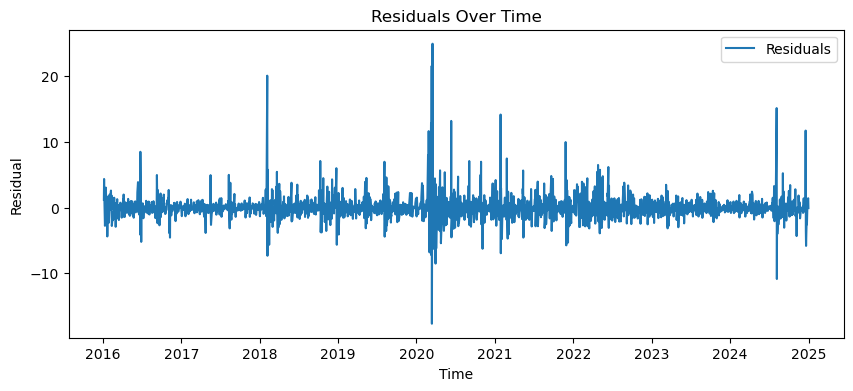

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats

# 1. Compute the residuals
df = merged_df 
df['residual'] = df['vol'] - df['predicted']

# 2. Plot the residuals over time
plt.figure(figsize=(10, 4))
plt.plot(df.index, df['residual'], label='Residuals')
plt.title("Residuals Over Time")
plt.xlabel("Time")
plt.ylabel("Residual")
plt.legend()
plt.show()

Observations:
- Occasional large spikes, indicating outliers 
- Residuals oscillate around zero (good)
- No obvious trend

/Users/benjaminang/anaconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



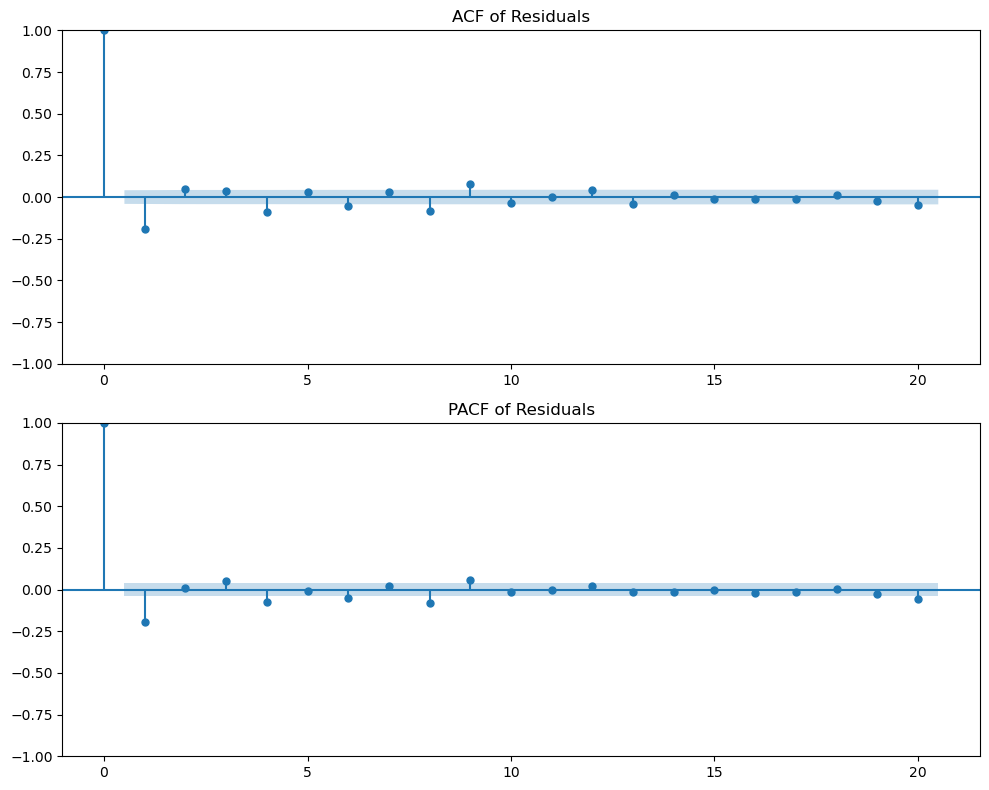

In [9]:
# 3. Plot the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(df['residual'], lags=20, ax=ax[0])
plot_pacf(df['residual'], lags=20, ax=ax[1])
ax[0].set_title("ACF of Residuals")
ax[1].set_title("PACF of Residuals")
plt.tight_layout()
plt.show()

Observations:
- No signification autocorrelation (since no spikes), captured temporal dependencies well
- Good fit

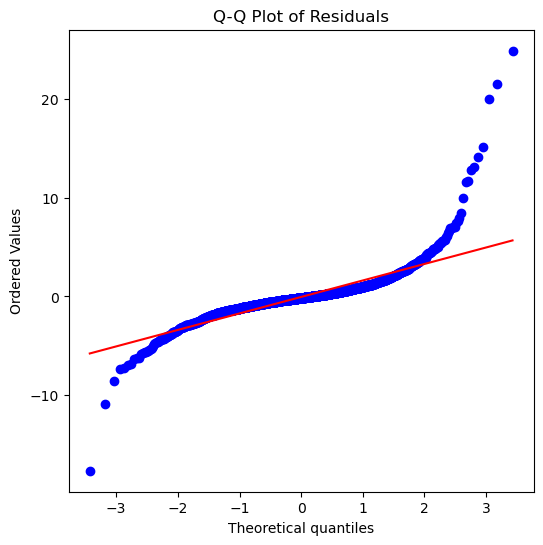

In [10]:
# 4. Q-Q Plot for normality check of the residuals
plt.figure(figsize=(6, 6))
stats.probplot(df['residual'], dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

Observations:
- Observed heavy tails, indicating that there are outliers
- Non-normal distribution, (probably t distribution)

/Users/benjaminang/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

/Users/benjaminang/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



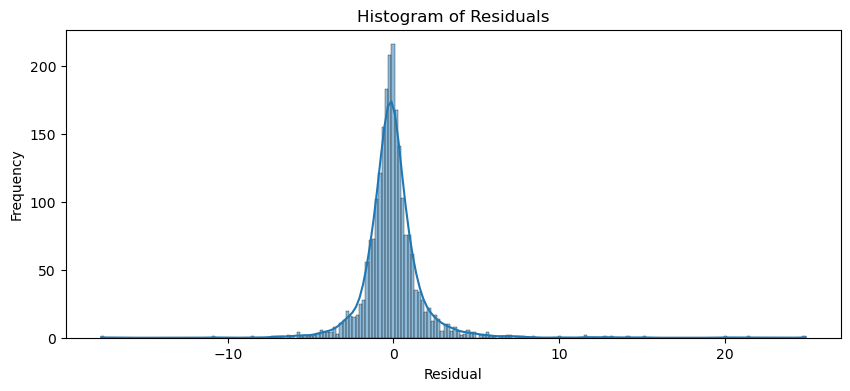

In [11]:
# 5. Histogram of the residuals
plt.figure(figsize=(10, 4))
sns.histplot(df['residual'], kde=True)
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

Observations:
- roughly centered around zero

Observations:
-  A very small p-value means we reject the null hypothesis that states that residuals are normally distributed.

Thoughts from plots:
- Standard fBM assumes increments follow a normal distribution, but clearly this isn't the case here.

In [12]:
import diagnostics

diagnostics.in_sample_diagnostics(merged_df['predicted_log_vol_diff'], merged_df['log_vol_diff'], merged_df['conditional_vol'])

Jarque-Bera test p-value: nan
Ljung-Box (residuals) p-value, nan
Ljung-Box (residuals^2) p-value, nan


In [13]:
# Compute 99% parametric VaR
merged_df['VaR_99'] = merged_df['predicted_log_vol_diff'].rolling(250).quantile(0.01)  # 1st percentile

var_stats = diagnostics.bernoulli_coverage_test(merged_df, var_col='VaR_99', predicted_col='log_vol_diff')
print(var_stats)

(7.860379014346108e-13, 51.31672161552228)


In [14]:
diagnostics.compute_hit_rate(predicted=merged_df['predicted_log_vol_diff'], actual=merged_df['log_vol_diff'])


Hit Rate: 51.12%


0.5111695137976346

### Value-at-Risk Forecast

In [15]:
# Compute violation ratio
var_stats = diagnostics.compute_var_violations(merged_df, var_col='VaR_99', predicted_col='log_vol_diff')
print(var_stats)

{'actual_exceedances': 60, 'expected_exceedances': 20.33000000000002, 'violation_ratio': 2.9513034923757964}


In [16]:
# Visualisation
import plots
plots.plot_var_violations(merged_df, var_col='VaR_99', predicted_col='log_vol_diff')